In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
import folium
import imp
import mpld3
from sqlalchemy import create_engine
sn.set_context('notebook')

# CROSSLINK: basic exploration of site data

The CROSSLINK project will focus on sites within the Oslo area. 

For a list of desirable datasets/metadata for monitoring stations in this project, see the e-mail from Nikolai received 15/05/2017 at 13:13. 

Initially, there are 8 rivers under consideration for the Norwegian component. These are shown on the map below (taken from Nikolai's start-up presentation).

<img src="https://github.com/JamesSample/misc/blob/master/images/crosslink_oslo_basin_rivers.jpg?raw=true" alt="Oslo rivers" style="width: 600px">

## 1. External data sources

There are lots of external data sources that should prove useful. Some idea below.

### 1.1. Catchment boundaries and properties

* Catchment boundaries for the 8 streams under consideration are available from the [NVE Atlas](http://atlas.nve.no/html5Viewer/?viewer=nveatlas) (pink and green polygons under *Nedborfelt* heading). As far as I can tell, it is not possible to export the raw vector data, but we can export the data as GeoTiffs, which can be easily traced. <br><br>

* The [NEVINA website](http://nevina.nve.no/) can be used to derive watersheds for any point on the "main" Norwegian stream network. The calculated boundaries can be exported as shapefiles, complete with summary statistics for (coarse) land cover and long-term rainfall & flow characteristics. An example of the summary output for the Lysakerelva is shown below.

<img src="https://github.com/JamesSample/misc/blob/master/images/nevina_lysakerelva_stats.png?raw=true" alt="NEVINA stats." style="width: 600px">

### 1.2. Land use

* The [NVE Atlas](http://atlas.nve.no/html5Viewer/?viewer=nveatlas) also includes basic land use data. Much of this is duplicated on the [NIBIO website](https://kilden.nibio.no/?X=7334000.00&Y=400000.00&zoom=0&lang=nb&topic=jordsmonn&bgLayer=graatone_cache&catalogNodes=38) (which may have a more flexible download interface?). Datasets available include: <br><br>

  * High-level land use classifications (*NVE Atlas*)
  * Something that looks like “capability for forestry”? (*NVE Atlas*)
  * Extents of coniferous, broadleaved and mixed woodland (*NVE Atlas*)
  * Cultivatable soils (NVE Atlas)
  * Basic agricultural land capability and vegetation cover (*NVE Atlas*)
  * Land quality and use limitations (*NIBIO > Jordsmonn*)
  * Soil drainage classes and drought vulnerability (*NIBIO > Jordsmonn*)
  * Limited information regarding land suitability for specific crop types (*NIBIO > Jordsmonn*)
  * Percentage of each cell that is agricultural (5 km raster; *NIBIO > Landskap*)
  * Average agricultural plot size in each cell (5 km raster; *NIBIO > Landskap*)
  * Area of grain grown per cell (5 km raster; *NIBIO > Landskap*)
  * Number of dairy cows per cell (5 km raster; *NIBIO > Landskap*)
  * Something to do with qualitative “land valuation”/ecosystem services ("bonitet")? (*NIBIO > Arealinformasjon*)

### 1.3. Geology

Detailed (1:50k) geology datasets for the Oslo area can be [downloaded from NGU](http://www.ngu.no/en/topic/datasets). A less detailed dataset (1:250k) is available for the whole country.

### 1.4. Flow data

* The NVE [xHydraII database](http://www4.nve.no/xhydra/) gives access to monitored flow and water temperature datasets (and sometimes modelled data too). It looks as though the [NVE Atlas](http://atlas.nve.no/html5Viewer/?viewer=nveatlas) may be an effective way identify the station numbers for use with xHydraII - see the layers under *Hydrologiske data > Målestasjoner i sanntid/Aktive måleserier/Målestasjon* for details. Unfortunately, I'm not sure there's much data available for our rivers of interest (but **check this in more detail**). <br><br> 

* There is also an incomplete list of NVE stations [here](http://www2.nve.no/h/hd/plotreal/Q/list.html) (but the xHydraII database contains much more than this).

### 1.5. Dams and other impoundments

* The [NVE Atlas](http://atlas.nve.no/html5Viewer/?viewer=nveatlas) gives locations of dams, and in some cases information regarding their purpose and type of construction. Similar data is also available via [NEVINA](http://nevina.nve.no/) (and the latter might provide more detailed information if required).

### 1.6. Other

It would be useful to have data on the following if possible:

* Additional discharge and/or water chemsitry for streams and lakes in the Oslo area
* More detailed land use (e.g. field scale)
* Information on buffer strips, field drains, ditches etc.
* Previous or ongoing river restoration
* Flow regulation and compensation flows
* Biological data and habitat surveys
* Population (must be able to get this somewhere?)
* Land valuation (agricultural, industrial, residential etc.)

## 2. Internal data sources

I'm sure a number of previous NIVA projects have focused on the area around Oslo, but without a bit more knowledge regarding what's been done before the information could be hard to find.

### 2.1. Data from the NIVABASE

As a start, try searching the NIVABASE for anything in the Oslo area. A bounding box defined by

    (lon_min, lon_max, lat_min, lat_max) = (10.60, 11.00, 59.87, 60.02)
    
should do it.

In [2]:
# Create db connection
r2_func_path = r'C:\Data\James_Work\Staff\Heleen_d_W\ICP_Waters\Upload_Template\useful_resa2_code.py'
resa2 = imp.load_source('useful_resa2_code', r2_func_path)

engine, conn = resa2.connect_to_resa2()

In [3]:
# Search database
sql = ("SELECT station_id, station_code, station_name, "
       "lake_or_river, latitude, longitude from resa2.stations "
       "WHERE latitude > 59.87 "
       "AND latitude < 60.02 "
       "AND longitude > 10.60 "
       "AND longitude < 11.00")

stn_df = pd.read_sql_query(sql, engine)
    
# Decode special characters
for col in stn_df.columns:
    if stn_df[col].dtype == object:
        stn_df[col] = stn_df[col].str.decode('windows-1252')

# Tidy
stn_df['station_id'] = stn_df['station_id'].astype(int)
stn_df.reset_index(inplace=True, drop=True)

print '%s stations identified in search area.' % len(stn_df)

stn_df.head()

36 stations identified in search area.


,station_id,station_code,station_name,lake_or_river,latitude,longitude
0,10294,AKEIHAL1,Halsjøen,L,59.875644,10.950644
1,15437,OSLOMA-3-1,Maridalsvannet,L,59.983703,10.778474
2,15271,OSLOMA-1-1,Skredderudtjern,L,60.011135,10.885698
3,15274,OSLOMA-1-2,Kjulstjern,L,60.010129,10.861692
4,15309,OSLOMA-2-1,Alnsjøen,L,59.965507,10.850947


Next, create a simple map showing station names and locations.

In [4]:
# Setup map
map1 = folium.Map(location=[59.95, 10.8],
                  zoom_start=11,
                  tiles='Stamen Terrain')

# Add clickable markers for sites
for idx, row in stn_df.iterrows():  
    folium.Marker([row['latitude'], row['longitude']], 
                  popup='%s (%s)' % (row['station_name'], 
                                     row['station_code'])).add_to(map1)

map1

It looks as though we have quite a lot of sites around Oslo, which is a good start. The next question is how many have been monitored recently. For this project, we need reasonable detailed monitoring within the last 5 years (roughly 2011 onwards).

The code below gets the number of water samples collected at each site and lists the dates of the first and last measurement.

In [5]:
# Get water sample data

# Container for output
df_list = []

# Loop over stations
for cde in stn_df['station_id'].unique():
    # Get sample data
    sql = ('SELECT MIN(station_id) as station_id, ' 
           'MIN(sample_date) as series_start, '
           'MAX(sample_date) as series_end, '
           'COUNT(*) as n_samples '
           'FROM resa2.water_samples '
           'WHERE station_id = %s' % cde)
    
    df = pd.read_sql_query(sql, engine)

    df_list.append(df)

# Combine results
samp_df = pd.concat(df_list, axis=0)

# Join to stn data
df = pd.merge(stn_df, samp_df, how='left',
              on='station_id')

df

,station_id,station_code,station_name,lake_or_river,latitude,longitude,series_start,series_end,n_samples
0,10294,AKEIHAL1,Halsjøen,L,59.875644,10.950644,NaT,NaT,NaN
1,15437,OSLOMA-3-1,Maridalsvannet,L,59.983703,10.778474,1992-03-23,1992-03-23 00:00:00,1.0
2,15271,OSLOMA-1-1,Skredderudtjern,L,60.011135,10.885698,1980-03-01,1992-03-03 00:00:00,2.0
3,15274,OSLOMA-1-2,Kjulstjern,L,60.010129,10.861692,1980-03-01,1992-03-03 00:00:00,2.0
4,15309,OSLOMA-2-1,Alnsjøen,L,59.965507,10.850947,1980-03-01,1992-03-14 00:00:00,2.0
5,15310,OSLOMA-2-10,Romstjern,L,59.987551,10.889375,1980-03-01,1992-03-15 00:00:00,2.0
6,15312,OSLOMA-2-2,Breidsjøen,L,59.979341,10.860321,1980-03-01,1992-03-14 00:00:00,2.0
7,15313,OSLOMA-2-3,Aurevann,L,59.992764,10.870219,1980-03-01,1992-03-14 00:00:00,2.0
8,15314,OSLOMA-2-4,S. Aurevannspytt,L,59.996346,10.870959,1980-03-01,1992-03-15 00:00:00,2.0
9,15315,OSLOMA-2-5,N. Aurevannspytt,L,59.999147,10.872911,1980-03-01,1992-03-15 00:00:00,2.0


This is less good - most of the monitoring at these sites seems to have stopped in the 1990s. In fact, looking at this output, there's **only one station with data collected after 2010** (at Alna; station ID 36225).

What does this data look like?

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000000027E10550>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x00000000263DAD30>], dtype=object)

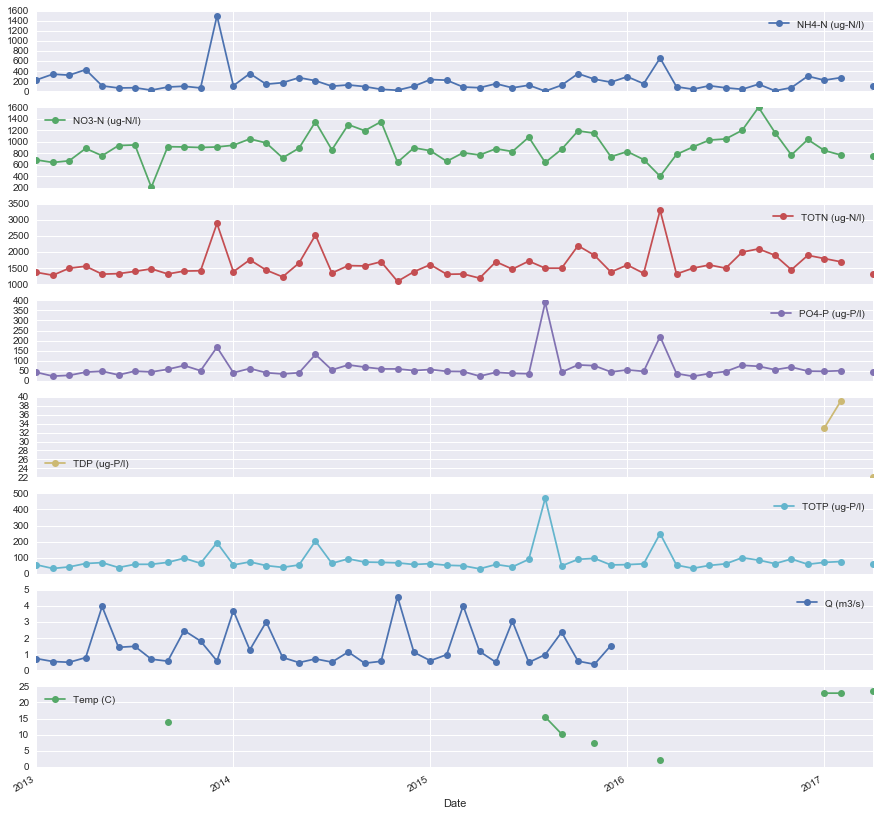

In [10]:
# Read data
in_xlsx = (r'C:\Data\James_Work\Staff\Nikolai_F\CROSSLINK\Raw_Data'
           r'\resa2_alna_stn_id_36225.xlsx')
chem_df = pd.read_excel(in_xlsx, sheetname='DATA')

# Set index and tidy
chem_df.index = chem_df['Date']
chem_df.drop(['Station ID', 'Station Code', 'Station name', 'Date'],
             inplace=True, axis=1)

# Remove unnecessary variables
chem_df.drop(['DOC (mg-C/l)', 'KOND (mS/m)', 'pH', 'SPM (mg/l)',
              'TOC (mg-C/l)', 'TURB860 (FNU)'],
             inplace=True, axis=1)

# Convert LOD strings to LOD i.e. remove '<'
for col in chem_df.columns:
    chem_df[col] = chem_df[col].astype(str).str.strip('<').astype(float)

# Reorder columns
chem_df = chem_df[['NH4-N (ug-N/l)', 'NO3-N (ug-N/l)', 'TOTN (ug-N/l)',
                   'PO4-P (ug-P/l)', 'TDP (ug-P/l)', 'TOTP (ug-P/l)',
                   'Q (m3/s)', 'Temp (C)']]

# Resample
chem_df = chem_df.resample('M').mean()

# Plot
chem_df.plot(subplots=True, marker='o', figsize=(15, 15))